In [34]:
import numpy as np
import tensorflow as tf
import folium
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Add, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten

In [35]:
def resnet_block(input_data, num_filters, kernel_size):
    x = Conv1D(num_filters, kernel_size, padding='same')(input_data)
    x = Activation('relu')(x)
    x = Conv1D(num_filters, kernel_size, padding='same')(x)
    x = Add()([x, input_data])
    x = Activation('relu')(x)
    return x


In [36]:
# Loading the dataset
data = pd.read_csv("metr-la.csv", parse_dates=['timestamp'], index_col='timestamp')

# Selecting the sensor data
sensor_data = data.iloc[:, 1:]

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sensor_data)

# Function to create input-output pairs
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Spliting the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Creating input-output pairs for train and test sets
lookback = 10
X_train, y_train = create_sequences(train_data, lookback)
X_test, y_test = create_sequences(test_data, lookback)

# Reshaping input to be 3D [samples, time steps, features] for ResNet
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], sensor_data.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], sensor_data.shape[1]))


In [37]:
def build_resnet_model(input_shape, num_blocks=3, num_filters=64, kernel_size=3, dropout_rate=0.5):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv1D(num_filters, kernel_size, padding='same')(inputs)
    x = Activation('relu')(x)

    for _ in range(num_blocks):
        x = resnet_block(x, num_filters, kernel_size)

    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    outputs = Dense(input_shape[1])(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [38]:
# Geting the input shape from the training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Building the ResNet model
model = build_resnet_model(input_shape)

# Compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [39]:
batch_size = 64
epochs = 50
validation_split = 0.2

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    shuffle=False
)


Epoch 1/50
343/343 [==============================] - 4s 9ms/step - loss: 0.0941 - val_loss: 0.0487
Epoch 2/50
343/343 [==============================] - 3s 9ms/step - loss: 0.0404 - val_loss: 0.0371
Epoch 3/50
343/343 [==============================] - 3s 8ms/step - loss: 0.0355 - val_loss: 0.0366
Epoch 4/50
343/343 [==============================] - 3s 8ms/step - loss: 0.0324 - val_loss: 0.0344
Epoch 5/50
343/343 [==============================] - 3s 9ms/step - loss: 0.0311 - val_loss: 0.0349
Epoch 6/50
343/343 [==============================] - 4s 10ms/step - loss: 0.0308 - val_loss: 0.0348
Epoch 7/50
343/343 [==============================] - 3s 9ms/step - loss: 0.0301 - val_loss: 0.0330
Epoch 8/50
343/343 [==============================] - 3s 9ms/step - loss: 0.0296 - val_loss: 0.0327
Epoch 9/50
343/343 [==============================] - 3s 9ms/step - loss: 0.0289 - val_loss: 0.0328
Epoch 10/50
343/343 [==============================] - 3s 9ms/step - loss: 0.0286 - val_loss: 0.032

In [40]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss (MSE): {test_loss}")
y_pred = model.predict(X_test)

214/214 [==============================] - 1s 2ms/step - loss: 0.0326
Test loss (MSE): 0.03255494311451912
214/214 [==============================] - 1s 2ms/step


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Rescaling the predicted and true values back to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculating MAE, RMSE, and R-squared
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")


Mean Absolute Error (MAE): 8.209056488453934
Root Mean Squared Error (RMSE): 12.619129448179578
R-squared: 0.6726699599893328


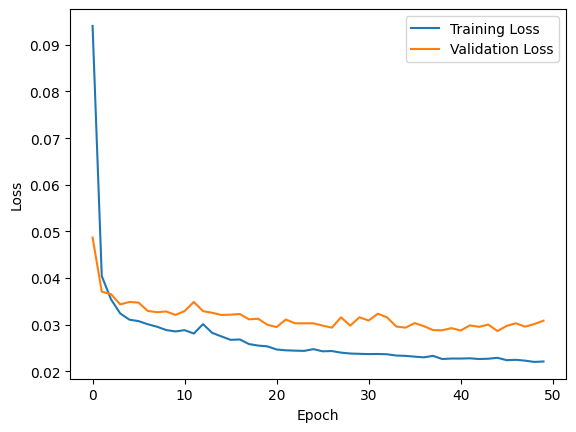

In [42]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

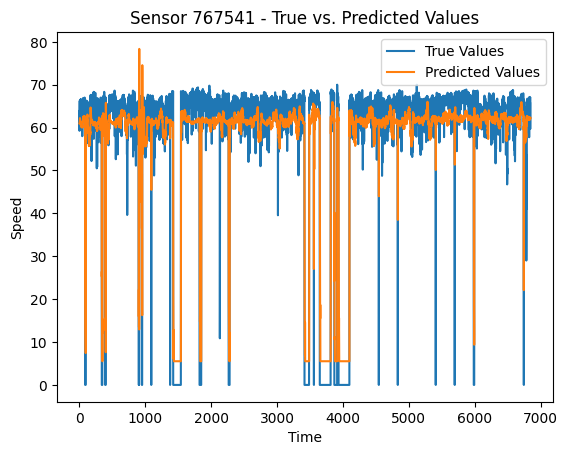

In [43]:
# Choose a specific sensor ID (e.g., '773869')
sensor_id = '767541'

# Find the index of the sensor ID in the dataset
sensor_index = list(data.columns).index(sensor_id) - 1  # Subtract 1 to account for the timestamp column

# Plot true vs. predicted values for the specific sensor
plt.plot(y_test_rescaled[:, sensor_index], label='True Values')
plt.plot(y_pred_rescaled[:, sensor_index], label='Predicted Values')
plt.title(f'Sensor {sensor_id} - True vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.show()

In [44]:
n = 100  # Number of future time steps to predict
input_sequence = X_test[-1]  # Use the last sequence in the test data as the input

future_predictions = []

for i in range(n):
    prediction = model.predict(input_sequence[np.newaxis, :, :])
    future_predictions.append(prediction[0])

    # Update the input_sequence with the new prediction
    input_sequence[:-1] = input_sequence[1:]
    input_sequence[-1] = prediction

# Rescale the future predictions back to the original scale
future_predictions_rescaled = scaler.inverse_transform(future_predictions)


1/1 [==============================] - 0s 17ms/step


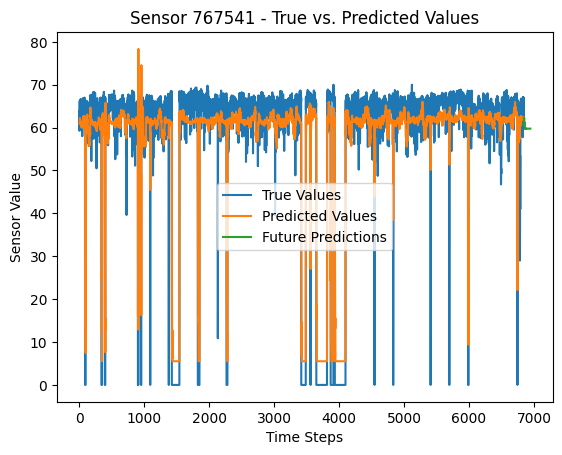

In [45]:
# Choose a specific sensor ID (e.g., '773869')
sensor_id = '767541'

# Find the index of the sensor ID in the dataset
sensor_index = list(data.columns).index(sensor_id) - 1  # Subtract 1 to account for the timestamp column

# Rescale the test data and predictions to the original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Plot the true values and predicted values for the sensor
plt.plot(y_test_rescaled[:, sensor_index], label='True Values')
plt.plot(y_pred_rescaled[:, sensor_index], label='Predicted Values')

# If you want to visualize the future predictions
if 'future_predictions_rescaled' in locals():
    prediction_start = len(y_test_rescaled)
    prediction_end = prediction_start + len(future_predictions_rescaled)
    prediction_range = range(prediction_start, prediction_end)
    plt.plot(prediction_range, future_predictions_rescaled[:, sensor_index], label='Future Predictions')

plt.xlabel('Time Steps')
plt.ylabel('Sensor Value')
plt.title(f'Sensor {sensor_id} - True vs. Predicted Values')
plt.legend()
plt.show()


In [46]:
# Read dataset
df = pd.read_csv("METR-LA.csv")

# Convert timestamp to datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set timestamp as index
df = df.set_index('timestamp')
train_ratio = 0.8
train_size = int(len(df) * train_ratio)

test_df = df[train_size:]

In [47]:
no_threshold=0
low_threshold = 30
medium_threshold = 50
given_time_index = 50  # Replace this with the desired index from the test dataset
future_time_index = 5  

traffic_speeds = test_df.iloc[given_time_index].values

In [48]:
def classify_traffic(sensor_ids, speeds, low_threshold, medium_threshold, no_threshold):
    traffic_levels = {}

    for sensor_id, speed in zip(sensor_ids, speeds):
        if speed == no_threshold:
            traffic_levels[sensor_id] = "no Traffic"
        elif speed >= medium_threshold:
            traffic_levels[sensor_id] = "Low"
        elif speed <= medium_threshold and speed >= low_threshold:
            traffic_levels[sensor_id] = "Medium"
        else:
            traffic_levels[sensor_id] = "High"

    return traffic_levels

In [49]:
traffic_levels = classify_traffic(test_df.columns, traffic_speeds, low_threshold, medium_threshold, no_threshold)

print("Low Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "Low"])

print("\nNo Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "no Traffic"])

print("\nMedium Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "Medium"])

print("\nHigh Traffic Sensors:")
print([sensor_id for sensor_id, level in traffic_levels.items() if level == "High"])


Low Traffic Sensors:
['773869', '767541', '767542', '717447', '717445', '773062', '767620', '737529', '767471', '773906', '769953', '769402', '769819', '717578', '717804', '767572', '767573', '773013', '764424', '717819', '769941', '760987', '718204', '769418', '773927', '774012', '774011', '767609', '769831', '773953', '767470', '764949', '767366', '773939', '774067', '769443', '767750', '767751', '767610', '773880', '717497', '717491', '717492', '765176', '717498', '718066', '765164', '769431', '717610', '767621', '772596', '767351', '716571', '767585', '773024', '717483', '717480', '764120', '717818', '718076', '718072', '767455', '767454', '761599', '773916', '716968', '769467', '717573', '717572', '717571', '717570', '764760', '769847', '767523', '769867', '717473', '759591', '764781', '765099', '762329', '767509', '769358', '772513', '718496', '773904', '718499', '761003', '717502', '759602', '763995', '773996', '773995', '717469', '764106', '717465', '764794', '717460', '717463'

In [50]:
future_time_index = 6  # Replace this with the desired index from the future_predictions
future_traffic_speeds = future_predictions_rescaled [future_time_index]
future_traffic_speeds = np.append(future_traffic_speeds,54.6697059)

In [51]:
future_traffic_levels = classify_traffic(test_df.columns, future_traffic_speeds, low_threshold, medium_threshold, no_threshold)
future_traffic_levels['769373']='Low'
print("Low Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "Low"])

print("\nNo Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "no Traffic"])

print("\nMedium Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "Medium"])

print("\nHigh Traffic Sensors:")
print([sensor_id for sensor_id, level in future_traffic_levels.items() if level == "High"])


Low Traffic Sensors:
['773869', '717445', '773062', '765604', '716339', '771667', '716337', '769953', '769402', '769403', '716941', '716960', '717804', '773012', '773013', '764424', '769388', '716328', '717819', '760987', '772140', '760024', '774012', '774011', '760650', '716956', '716554', '773953', '716955', '764949', '773939', '767750', '767751', '767610', '717490', '717493', '718066', '767350', '767351', '773023', '767585', '773024', '718379', '717481', '717486', '772151', '717488', '717818', '718076', '718072', '767454', '761599', '717099', '773916', '769467', '717576', '717573', '717572', '717571', '717570', '764760', '718089', '717608', '767523', '718090', '769867', '717472', '717473', '716953', '716951', '767509', '769358', '716958', '769346', '773904', '764853', '717502', '765265', '773996', '773995', '717469', '717468', '764106', '764794', '717461', '717460', '716943', '772669', '717582', '717583', '716949', '772178', '716939', '764101', '767554', '773975', '717513', '767495'

In [52]:
def plot_sensor_positions_on_map(sensor_positions, traffic_levels):
    # Create a map centered at the average latitude and longitude of the sensors
    avg_lat = sensor_positions["latitude"].mean()
    avg_lon = sensor_positions["longitude"].mean()
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)

    # Define colors for different traffic levels
    colors = {
        "no Traffic": "gray",
        "Low": "green",
        "Medium": "orange",
        "High": "red",
    }

    # Add markers for each sensor
    for idx, row in sensor_positions.iterrows():
        sensor_id = row["sensor_id"]
        lat = row["latitude"]
        lon = row["longitude"]
        level = traffic_levels[sensor_id]
        color = colors[level]

        folium.Marker(
            location=[lat, lon],
            icon=folium.Icon(color=color),
            tooltip=f"Sensor ID: {sensor_id}, Traffic: {level}",
        ).add_to(m)

    return m


In [53]:
# Read sensor positions from the file
sensor_positions = pd.read_csv("graph_sensor_locations.csv")

# Map sensor IDs to their index in the dataset
sensor_id_to_index = {sensor_id: idx for idx, sensor_id in enumerate(sensor_positions["sensor_id"])}

# Classify traffic levels for the given time index
traffic_levels_given_time = classify_traffic(
    sensor_positions["sensor_id"],
    traffic_speeds,
    low_threshold,
    medium_threshold,
    no_threshold,
)

# Plot the sensor positions with their traffic classification on a map
m = plot_sensor_positions_on_map(sensor_positions, traffic_levels_given_time)
m.save("sensor_positions_map.html")  # Save the map as an HTML file
m  # Display the map in the notebook


In [54]:
# Read sensor positions from the file
sensor_positions = pd.read_csv("graph_sensor_locations.csv")

# Map sensor IDs to their index in the dataset
sensor_id_to_index = {sensor_id: idx for idx, sensor_id in enumerate(sensor_positions["sensor_id"])}



# Classify traffic levels for the given time index
traffic_levels_given_time = classify_traffic(
    sensor_positions["sensor_id"],
    future_traffic_speeds,
    low_threshold,
    medium_threshold,
    no_threshold,
)

# Plot the sensor positions with their traffic classification on a map
m = plot_sensor_positions_on_map(sensor_positions, traffic_levels_given_time)
m.save("sensor_positions_map.html")  # Save the map as an HTML file
m  # Display the map in the notebook
